# Challenge 2
Throughout this notebook we apply a gradient boosting model to diamond pricing following these steps:
- **prepare the data** to be fed to the pricing model;
- search for the **best pricing model**;
- **inspect** how the model assigns prices to diamonds.

## Dependency Installation
As a price prediction model we employ an XGBoost model. We need to upgrade the pre-installed XGBoost version that has been deprecated:
- Run the cell below
- Click on the "Restart Runtime" button at the end of the execution output (if no button appears you are good to go)

In [1]:
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


## Loading the Dataset


In [2]:
# clone the dataset from github
!git clone https://github.com/DPaletti/xtream-assignment/

Cloning into 'xtream-assignment'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 299 (delta 115), reused 226 (delta 98), pack-reused 50
Receiving objects: 100% (299/299), 4.40 MiB | 5.68 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [3]:
# load the dataset from the csv file
import pandas as pd
dataset = pd.read_csv("./xtream-assignment/datasets/diamonds/diamonds.csv")

## Pre-Processing
We prepare the data for the machine learning model:
- **remove points** with price smaller than 0 and x, y or z equals to 0;
- remove **redundant features** x, y and z;
- **convert grading scales** to integers;
- split the dataset in **train and test** set;

These steps are further discussed in [Notebook 1](https://colab.research.google.com/drive/1yHl4ymnnhYKh9QwEorJ4ZNy-SYo6zCAu?usp=sharing).

In [4]:
# Setting globals
seed = 0
target = "price"
test_size = 0.2
categorical_features = ["cut", "color", "clarity"]

In [5]:
# Defining mappings from categorical to integer
from functools import reduce
from typing import List
import string

cut_mapping = {
    "Ideal": 4,
    "Premium": 3,
    "Very Good": 2,
    "Good": 1,
    "Fair": 0,
}

color_mapping = {color_grade: value 
                 for value, color_grade 
                 in enumerate(string.ascii_uppercase[3:])}

clarity_mapping = {
    "IF": 7,
    "VVS1": 6,
    "VVS2": 5,
    "VS1": 4,
    "VS2": 3,
    "SI1": 2,
    "SI2": 1,
    "I1": 0
}

mappings = [cut_mapping, color_mapping, clarity_mapping]



In [6]:
# Categorical to integer transformation functions
from functools import reduce
from typing import Dict, List

def convert_to_ordinal(dataset: pd.DataFrame, feature_map: Dict[str, int]) -> pd.DataFrame:
  """Convert a categorical feature to ordinal in a given dataset"""
  return dataset.replace(feature_map)

def convert_all_to_ordinal(dataset: pd.DataFrame, 
                           feature_maps: List[Dict[str, int]]) -> pd.DataFrame:
  """Convert a list of categorical features to ordinal in a given dataset"""
  return reduce(convert_to_ordinal, feature_maps, dataset)

In [7]:
from sklearn.model_selection import train_test_split

# remove problematic data points
cleaned_dataset = dataset.drop(dataset[dataset.price <=0].index)
cleaned_dataset = cleaned_dataset.drop(
    cleaned_dataset[
      (cleaned_dataset["x"] == 0) 
    | (cleaned_dataset["y"] == 0) 
    | (cleaned_dataset["z"] == 0)].index)

# remove correlated features
cleaned_dataset = cleaned_dataset.drop(["x", "y", "z"], axis=1)

# convert ordinal values to numeric
cleaned_dataset = convert_all_to_ordinal(cleaned_dataset,
                                                mappings)

# split
train, test = train_test_split(cleaned_dataset, 
                               test_size=test_size, 
                               random_state=seed)
samples_train = train.drop([target], axis=1)
targets_train = train[target]
samples_test = test.drop([target], axis=1)
targets_test = test[target]

## Training and Evaluation
In this section we train and evaluate our price prediction model. We decided to use a **gradient boosting model**. Such technique employs several weak models combined together to build a stronger model. In our case the weak models are **decision trees**:

<img src="https://drive.google.com/uc?export=view&id=1_I-R3pzsZ8Z0CHC_xjVb5wlat84F-mGk" width=50%>

A decision tree has a condition in each of its nodes and two arcs which represent whether the condition is satisfied or not. The last nodes (i.e. leaves) represent the decision taken by the tree. In our case, the decision is the price attributed to a diamond given its features. For example, the tree above assigns to a diamond with carat lower than 0.47 a price of 390 by first checking if carat is lower than 1, then checking if carat is lower than 0.61 and finally checking if carat is lower than 0.47.

Gradient boosting models use **multiple of these trees** to take a decision and sum each decision to build the final price.

We tried several models and then found that the best one hosts 9 trees with depth equals to 3 (as the one above). Such model achieves an **accuracy of 95.6% on the test set**.



In [ ]:
# Runs random search with cross-validation to find the best hyperparameters
# ~30 seconds running time

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

regressor = XGBRegressor(tree_method="gpu_hist", 
                         sampling_method="gradient_based",
                         random_state=seed)
hyperparameters = {
        # learning rate
        "eta": np.geomspace(0.1, 1, endpoint=False),
        # L1 regularization
        "alpha": np.linspace(0,1),
        # L2 regularization
        "lambda": np.linspace(0, 1),
        # subsample rate prior to growing the trees
        "subsample": np.linspace(0.1, 1),
        # max_depth set low for interpretability
        "max_depth": [3],
        # number of trees (preferring lower estimators solutions)
        "n_estimators": list(range(1, 10))
    }


hyperparameter_search = RandomizedSearchCV(
                           regressor, 
                           hyperparameters, 
                           scoring="r2",
                           cv=3,
                           n_iter=300,
                           verbose=3,
                           random_state=seed)

hyperparameter_search.fit(samples_train, targets_train)
model = hyperparameter_search.best_estimator_
model.save_model("model.json")

In [37]:
print("R2 score achieved: " + str(model.score(samples_test, targets_test)))

R2 score achieved: 0.95628899213347


## Model Interpretation

As discussed in the previous section, our model is composed of 9 decision trees which we will now inspect.


### The Importance of Depth for Very Large Diamonds
<img src="https://drive.google.com/uc?export=view&id=1v2nnlhYfxj5vbsTUsh2Ch7v4w9sklNo0" width=50%>

The tree above is the only one that does not have a condition on carat as the first node (i.e. the root). On top of this, it is the only incomplete tree (see the bottom leaf). If depth is lower than 63.9 mm and carat is larger than 2.53 the last condition is skipped and a price is directly assigned to the diamond. Such price is exceptionally high with respect to the prices assigned. This being the only tree which takes into account depth, 63.9 mm can be clearly interpreted as a **threshold value for depth** in our model.

### Large VVS Diamonds
<img src="https://drive.google.com/uc?export=view&id=1_I-R3pzsZ8Z0CHC_xjVb5wlat84F-mGk" width=50%>

In this specific tree carat is completely dominant, all nodes except one contain carat conditions. This surely demonstrates the importance of carat for our model but it also gives us a chance to isolate the effect of clarity.
We can see that for the same diamond with carats between 1 and 1.38 the clarity plays a very important role in determining the price, in particular a clarity value larger than 4 makes a diamond 1.5 more expensive than a diamond with lower clarity. This means that **a VVS diamond costs 1.5x more than a non-VVS one** given a size between 1 and 1.38 carats.

### Colorless Diamonds and I1 Clarity
<img src="https://drive.google.com/uc?export=view&id=1F5AlCl6T5IOdfALGVsqpJlC5387u38dX" width=50%>

As for clarity also color plays a very important role for rather large diamonds.
For diamonds larger than 1.21 carats but smaller than 1.60 carats a color which falls in the **colorless spectrum (color < 4) makes the price grow more than 2x**.
On top of this, we see also the dramatic effect of I1 clarity. For diamonds larger than 1.60 carats a clarity of I1 makes the price go from 3669\$ to 860\$.

### Remaining Trees: the Imporance of Carat and the Absence of Table
Below we plotted the 6 remaining trees. **All roots are occupied by a condition on carat** which confirms the importance of such feature. By a deeper inspection we also notice that **table is ignored**, no node hosts a condition on table. We expect that more complex models would take also table into account probably achieving higher accuracies. We opted for a simpler more inspectable model. Finally, we also see that **cut plays a marginal role**, there are only two nodes with a condition on cut (in the second tree on first row and the third one on second row). Both nodes check whether the diamond has an ideal cut or not stating how the lower cut grades are very similary to each other for our model.

<table><tr>
 <td><img src="https://drive.google.com/uc?export=view&id=1-CSwTW_X6uUwiKk_yO4l09pSN-Cs6Byw"></td>
 <td><img src="https://drive.google.com/uc?export=view&id=15dG0n5Tq2Mp30Nl3dFDvEMM7Nyc1dPjT"></td>
  <td><img src="https://drive.google.com/uc?export=view&id=1PTQrYmzwzFCeN_wzbYsIf1mhjDFnqnEU"></td>
 </tr>
<tr>
  <td><img src="https://drive.google.com/uc?export=view&id=14qOgcyF9lGzAtbu2kmJxB48NBIxckoU2"></td>
 <td><img src="https://drive.google.com/uc?export=view&id=13BCPa9vMhd0ask0XSnDdWDZ-BCdG40vl"></td>
 <td><img src="https://drive.google.com/uc?export=view&id=1aKARtGAfFENh-c4UkYffmsLbKE1wXXE8"></td>
 </tr>
 </table>

### Feature Importance

Finally, global feature importance further confirms our analysis:
- carat      0.828548
- clarity    0.095106
- color      0.052740
- cut        0.013860
- depth      0.009746
- table      0.000000


 

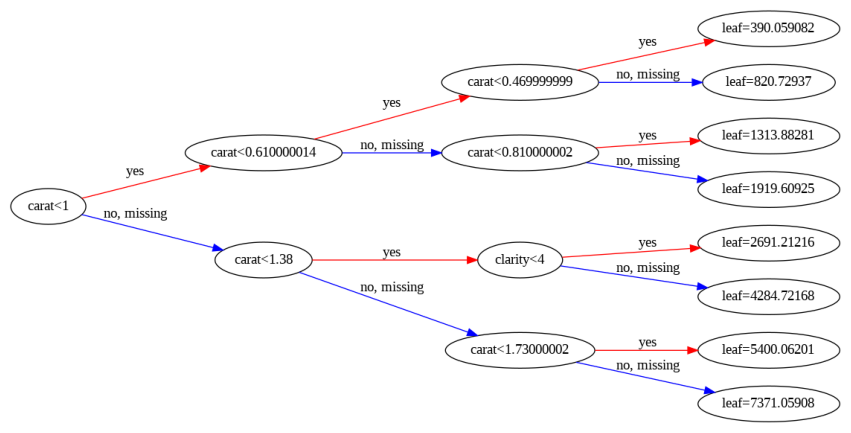

In [33]:
# Plotting the tree in "Large VVS Diamonds"

from xgboost import plot_tree
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
plot_tree(model, num_trees=0, rankdir="LR")

In [38]:
feature_importance = pd.Series(index=samples_train.columns, data=model.feature_importances_).sort_values(ascending=False)
feature_importance

carat      0.828548
clarity    0.095106
color      0.052740
cut        0.013860
depth      0.009746
table      0.000000
dtype: float32